<a href="https://colab.research.google.com/github/shy222/DSCI498-Final-Project/blob/main/DSCI498_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Installing necessary libraries
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline
import tensorflow_datasets as tfds

from matplotlib import gridspec


Loaded the "RockPaperScissors" dataset from Tensorflow Datasets

In [7]:
ds = tfds.load('RockPaperScissors', split='train', as_supervised=True, shuffle_files=True)

Shuffled the dataset to ensure randomness.

In [8]:
ds = ds.shuffle(1000).batch(128)

Each image has a shape of (300, 300, 3), indicating height, width, and
3 color channels (RGB).

The target variable (label) in each element of the dataset is represented as a tensor with a shape of (None,) and a data type of int64. This means that the target variable is a one-dimensional array (vector) with a variable batch size, where each element corresponds to a specific class or category.

In [9]:
ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

This label_dict dictionary maps the integer labels to their corresponding class names in the dataset.

In [10]:
# Create dictionary of target classes
label_dict = {
 0: 'Rock',
 1: 'Paper',
 2: 'Scissors'
}

Creates a visualization of a batch of images from the dataset along with their corresponding labels

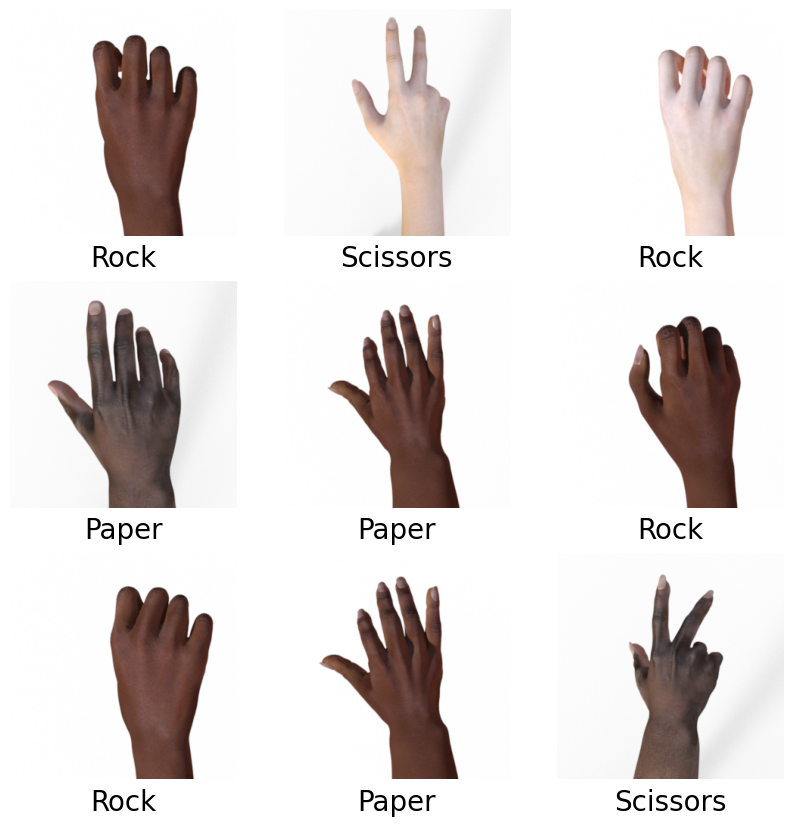

In [11]:
plt.figure(figsize=(10, 10))
for image, label in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        lab = np.array(label[i])
        plt.text(0.5, -0.1, s = label_dict[int(lab)], horizontalalignment='center',
     verticalalignment='center', transform = ax.transAxes, fontsize=20)
        plt.imshow(image[i])
        plt.axis("off")

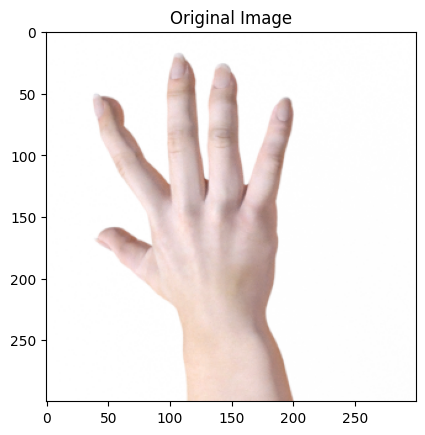

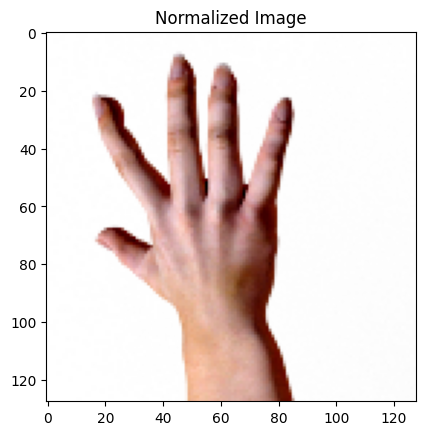

In [12]:

@tf.function
def normalization(tensor):
    tensor = tf.image.resize(tensor, (128,128))
    tensor = tf.subtract(tf.divide(tensor, 127.5), 1)
    return tensor



# Iterate over the dataset and retrieve the first image
for sample_image, _ in ds.take(1):
    # Display the original image
    plt.imshow(sample_image[0])
    plt.title('Original Image')
    plt.show()

    # Normalize the image
    normalized_image = normalization(sample_image)

    # Display the normalized image
    plt.imshow(normalized_image[0])
    plt.title('Normalized Image')
    plt.show()



In [13]:
for img, label in ds.take(1):
    img = tf.cast(img, tf.float32)
    imgs = normalization(img)
    print(imgs.shape)

(128, 128, 128, 3)


In [14]:
BATCH_SIZE=128
latent_dim = 100

In [15]:
# label input
con_label = layers.Input(shape=(1,))

# latent vector input
latent_vector = layers.Input(shape=(latent_dim,))

In [16]:
def label_conditioned_generator(n_classes=3, embedding_dim=100):
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    # linear multiplication
    nodes = 4 * 4
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((4, 4, 1))(label_dense)
    return label_reshape_layer

def latent_input(latent_dim=100):
    # image generator input
    nodes = 512 * 4 * 4
    latent_dense = layers.Dense(nodes)(latent_vector)
    latent_dense = layers.ReLU()(latent_dense)
    latent_reshape = layers.Reshape((4, 4, 512))(latent_dense)
    return latent_reshape

In [17]:
from graphviz import Digraph

def plot_latent_vector_flow():
    dot = Digraph()

    # Add nodes
    dot.node('latent_vector', 'Latent Vector')
    dot.node('dense', 'Dense Layer')
    dot.node('relu', 'ReLU Activation')
    dot.node('reshape', 'Reshape Layer')

    # Add edges
    dot.edge('latent_vector', 'dense')
    dot.edge('dense', 'relu')
    dot.edge('relu', 'reshape')

    # Render and save the diagram
    dot.render('latent_vector_flow', format='png', cleanup=True)

# Plot the flow diagram for latent vector input
plot_latent_vector_flow()

In [18]:
from graphviz import Digraph

def plot_label_conditioned_flow():
    dot = Digraph()

    # Add nodes
    dot.node('conditioned_label', 'Conditioned Label')
    dot.node('embedding', 'Embedding Layer')
    dot.node('dense', 'Dense Layer')
    dot.node('reshape', 'Reshape Layer')

    # Add edges
    dot.edge('conditioned_label', 'embedding')
    dot.edge('embedding', 'dense')
    dot.edge('dense', 'reshape')

    # Render and save the diagram
    dot.render('label_conditioned_flow', format='png', cleanup=True)

# Plot the flow diagram for label conditioned input
plot_label_conditioned_flow()


Define the architecture for the generator model in a conditional
generative adversarial network (CGAN).
Combines label-conditioned and latent vector inputs to generate realistic images.
Utilizes convolutional transpose layers to upsample the input and produce high-resolution images.
Includes batch normalization and ReLU activation for stability and non-linearity.
Outputs images with RGB color channels scaled to the range [-1, 1] using the tanh activation function.
Model is defined using the Keras functional API.


In [19]:
# define the final generator model
def define_generator():
    label_output = label_conditioned_generator()
    latent_vector_output= latent_input()
    # merge label_conditioned_generator and latent_input output
    merge = layers.Concatenate()([latent_vector_output, label_output])

    x = layers.Conv2DTranspose(64 * 8, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(merge)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)

    x = layers.Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)

    x = layers.Conv2DTranspose(64 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)


    x = layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x)


    out_layer = layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_6')(x)


   # define model
    model = tf.keras.Model([latent_vector,  con_label], out_layer)
    return model

In [20]:
conditional_gen = define_generator()

In [21]:
conditional_gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 8192)                 827392    ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               300       ['input_1[0][0]']             
                                                                                              

plot_model to visualize the architecture diagram of the generator model.
The resulting diagram will be saved as 'generator_architecture.png'

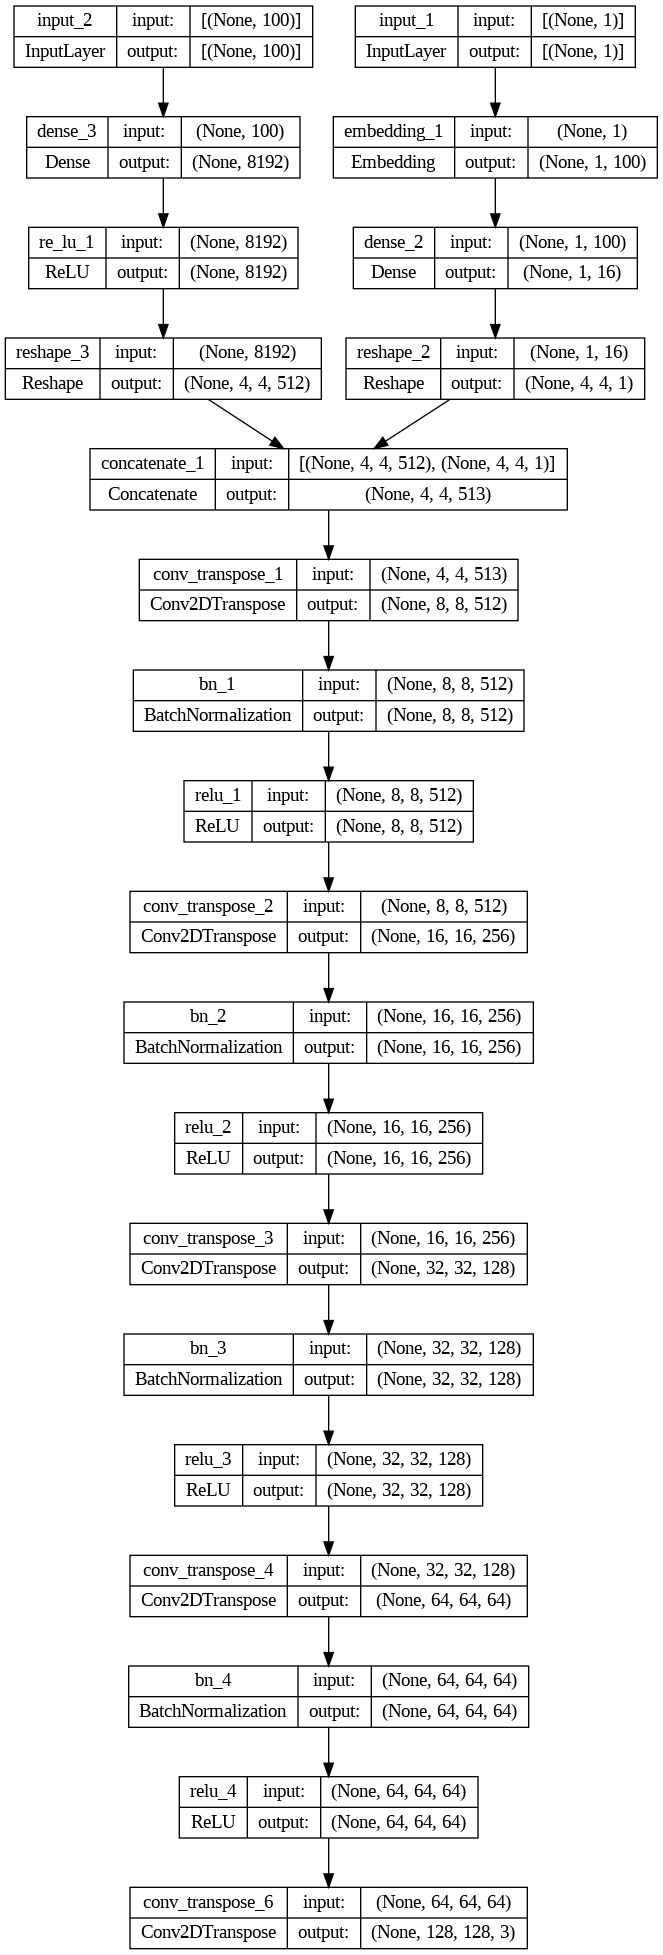

In [22]:
from tensorflow.keras.utils import plot_model

# Define the generator model
generator_model = define_generator()

# Plot the architecture diagram
plot_model(generator_model, to_file='generator_architecture.png', show_shapes=True, show_layer_names=True)
